**Title:**
Analyzing Heart Data from Cleveland to Predict the Possibility of Heart Disease Based on Maximum Heart Rate Achieved , Age and Serum Cholesterol

**Introduction:**
Heart disease encompasses many prevalent heart related conditions where blood flow to the heart has decreased; to understand the likelihood of heart disease, factors such as maximum heart rate achieved, age, serum cholesterol, resting heart rate, and ST depression induced by exercise, need to be analyzed. Heart health is interconnected to the maximum heart rate an individual can achieve as it changes with age. It was observed by the American Journal of Cardiology that any type of angina, also known as chest pain was observed to have a 30% increase with the increase of age (Perret-Guillaume et al., 2009; Pepine et al., 1994). Further, a study conducted by the NIH found that a lower maximum heart rate achieved was associated with a higher risk of dying from heart disease (Sandvik et al., 1995). Another research article indicated that the decreasing incidence of ischaemic heart disease among different ages is related to decreasing serum cholesterol concentration (Law et al., 1994). This supports the relationship of heart disease with serum cholesterol levels. Further, a study conducted by the NIH found that ST depression induced by exercise, which is a stress test conducted to test the heart, was deemed as a reliable factor when it came to diagnosing obstructive coronary atherosclerosis which is a type of heart disease. Last, an article by Harvard Health delves into research that found a higher resting heart rate was associated with a greater risk of heart disease (Solan, 2021).  In this project, we will investigate the predictability of diagnosis of heart diseases based on the maximum heart rate achieved, age, serum cholesterol, resting heart rate, and ST depression induced by exercise relative to rest from the Cleveland heart disease database.

**Methods & Results:**
Begin by loading in the necessary libraries, then read in the csv file, processed.cleveland.data from the web. Firstly, add headers to the columns.


In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ──────────────────────

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
cleveland <- read_csv(url, col_names = FALSE)
#add headers
colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
head(cleveland)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Filter rows with missing values indicated by “?” out. Then mutate the data to make the data more readable and select the age, maximum heart rate achieved, serum cholesterol and diagnosis of heart disease columns.

In [3]:
# tidying the data
# removing rows which have NA values that are indicated by ?
cleveland_no_missing <- cleveland |>
    filter(age != '?', sex != '?', cp != '?', trestbps != '?', chol != '?', 
           fbs != '?', restecg != '?', thalach != '?', exang != '?', 
           oldpeak != '?', slope != '?', ca != '?', thal != '?', num != '?') |>
    na.omit()

# mutate the numbers into strings
cleveland_mutated <- cleveland_no_missing |>
    mutate(diagnosis = (if_else(num == 0, "Undiagnosed", "Diagnosed"))) 

# selecting the columns which we will be using in our analysis
cleveland_selected <- cleveland_mutated |>
    select(diagnosis, age, chol, thalach, trestbps, oldpeak) 

head(cleveland_selected)

diagnosis,age,chol,thalach,trestbps,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Undiagnosed,63,233,150,145,2.3
Diagnosed,67,286,108,160,1.5
Diagnosed,67,229,129,120,2.6
Undiagnosed,37,250,187,130,3.5
Undiagnosed,41,204,172,130,1.4
Undiagnosed,56,236,178,120,0.8


The column names each stand for:

    diagnosis - Whether or not the person is diagnosed with some heart disease
    age - Age (years)
    chol - Serum Cholesterol Concentration (mg/dl)
    thalach - Maximum Heart Rate Achieved (BPM) 
    trestbps - Resting Blood Pressure (mmHg)
    oldpeak - ST depression induced by exercise relative to rest

Split into a training set which makes up 75% of the tidy data set and a testing set which makes up the remaining 25%.

In [4]:
set.seed(1000)
# splitting the dataset into training set and testing set, produce the training set table
cleveland_split <- initial_split(cleveland_selected, prop = 0.75, strata = diagnosis)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

head(cleveland_train)

diagnosis,age,chol,thalach,trestbps,oldpeak
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Diagnosed,67,286,108,160,1.5
Diagnosed,67,229,129,120,2.6
Diagnosed,62,268,160,140,3.6
Diagnosed,53,203,155,140,3.1
Diagnosed,48,229,168,110,1.0
Diagnosed,58,284,160,120,1.8


Explore the relationships between the predictors and the diagnosis of the individual. 

In [5]:
options(repr.plot.width = 12, repr.plot.height = 10)

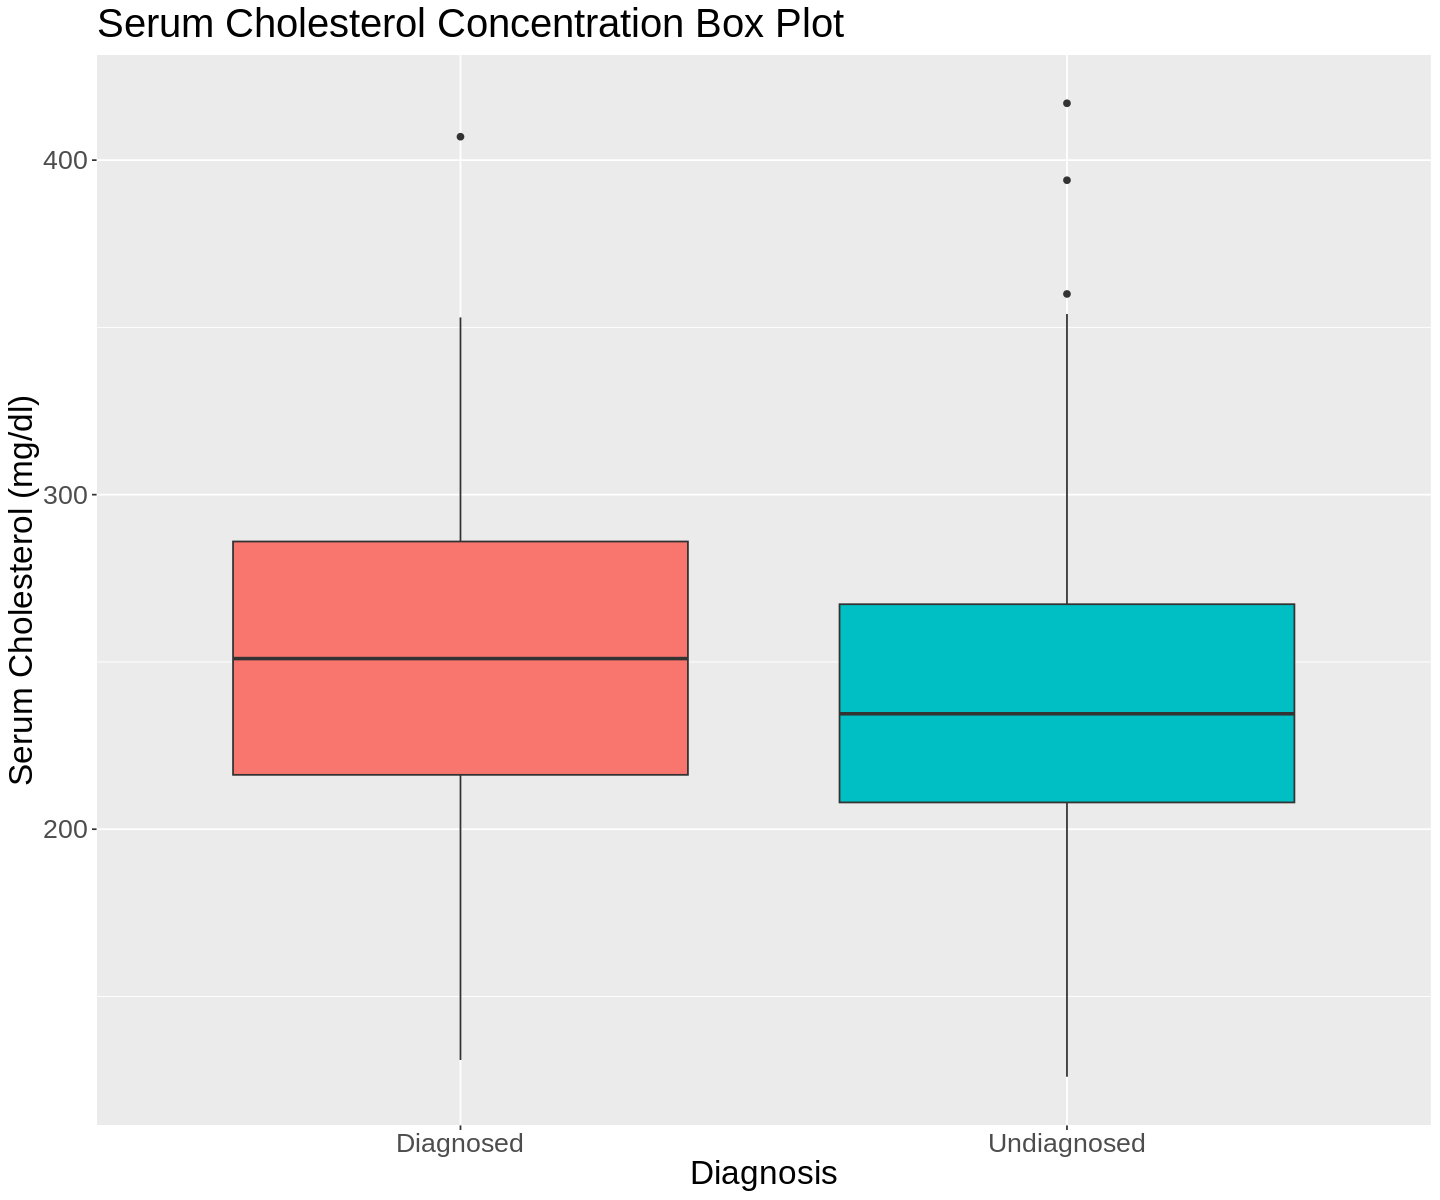

In [6]:
chol_box <- cleveland_train |>
    ggplot(aes(x = diagnosis, y = chol, fill = diagnosis)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Serum Cholesterol (mg/dl)",
         color = "Diagnosis") +
    theme(text = element_text(size = 20)) +
    ggtitle("Serum Cholesterol Concentration Box Plot")

chol_box

The distribution of data in the Serum Cholesterol Concentration box plot for Undiagnosed and Diagnosed people appears to be symmetric. The Serum Cholesterol Concentration of most Diagnosed people is around 248 mg/dl and Undiagnosed people’s Serum Cholesterol Concentration is usually around 240 mg/dl. Therefore, we can say that Serum Cholesterol Concentration has a small impact on diagnosis.

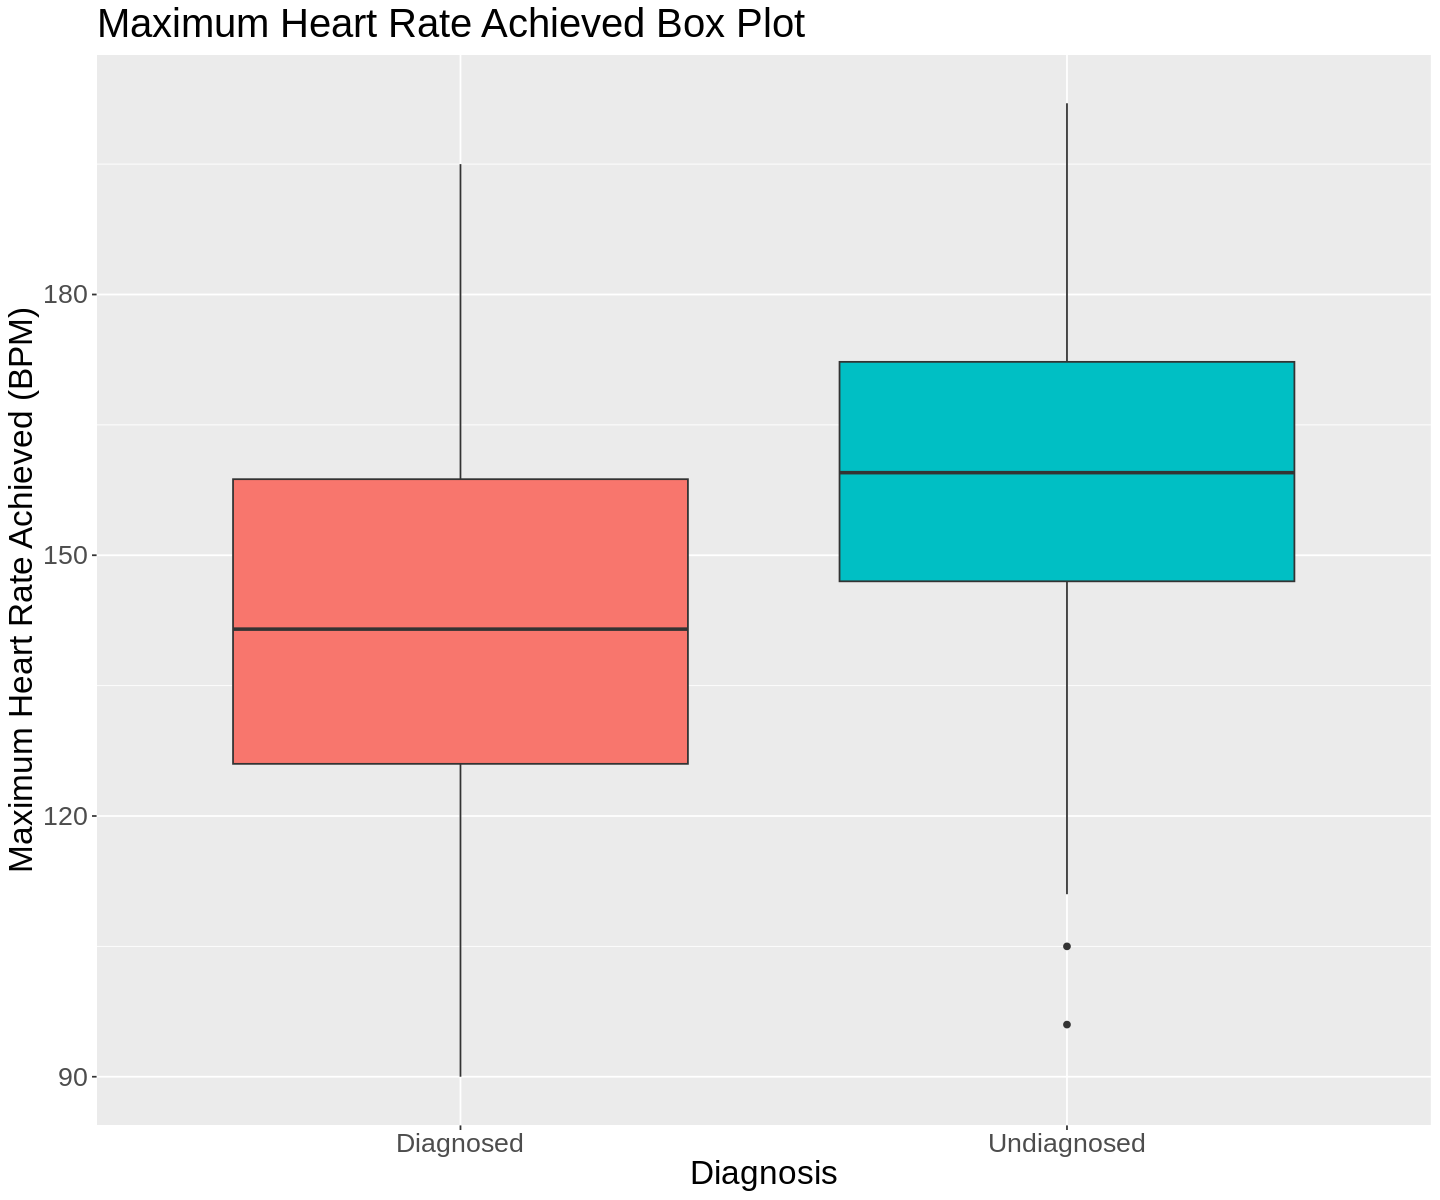

In [7]:
thalach_box <- cleveland_train |>
    ggplot(aes(x = diagnosis, y = thalach, fill = diagnosis)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Maximum Heart Rate Achieved (BPM)",
         color = "Diagnosis") +
    theme(text = element_text(size = 20)) +
    ggtitle("Maximum Heart Rate Achieved Box Plot")

thalach_box

In the Maximum Heart Rate Achieved box plot, the Diagnosed exhibits a slight left-skewed distribution in the boxplot and the boxplot for Undiagnosed shows a roughly symmetrical distribution. Two sets of data are distributed in a similar way, but Undiagnosed is located to the right of the other. The median of Diagnosed is less than the lower quartile of the Undiagnosed. So we can conclude that Maximum Heart Rate has an impact on diagnosis.

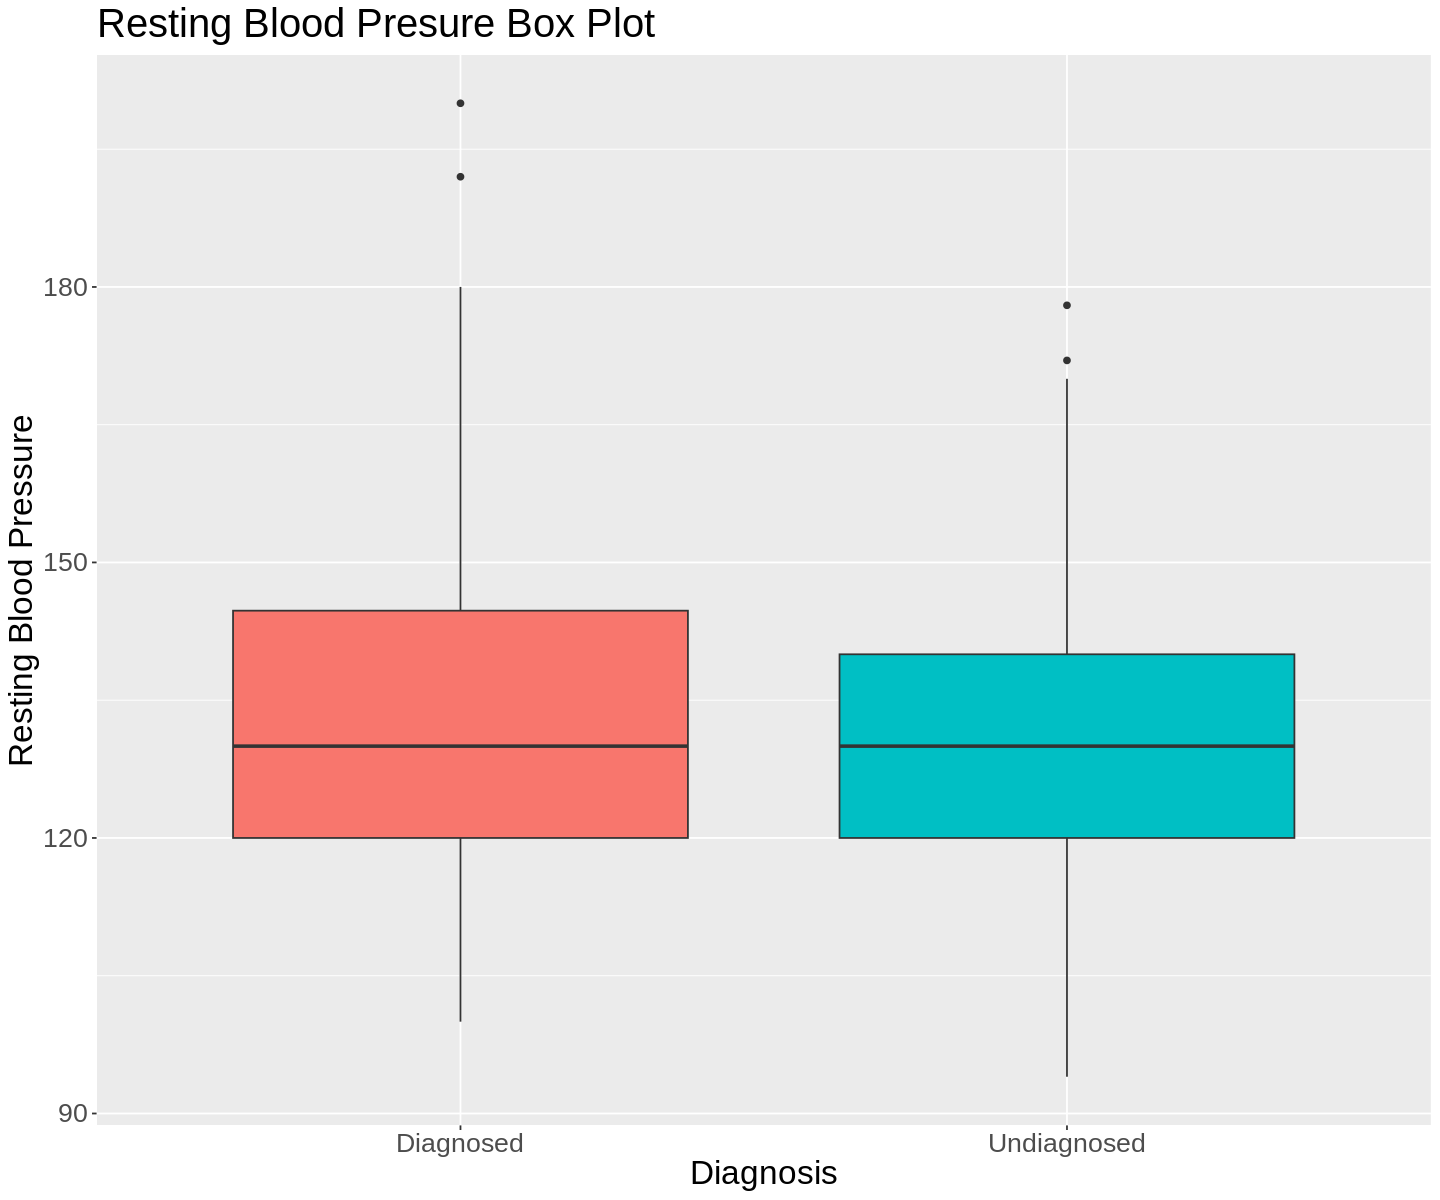

In [8]:
trestbps_box <- cleveland_train |>
    ggplot(aes(x = diagnosis, y = trestbps, fill = diagnosis)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Resting Blood Pressure",
         color = "Diagnosis") +
    theme(text = element_text(size = 20)) +
    ggtitle("Resting Blood Presure Box Plot")

trestbps_box

The case with Resting Blood Pressure box plot is similar to the situation in the Serum Cholesterol Concentration box plot. There doesn't seem to be a strong correlation between resting blood pressure and the diagnosis of the individual.

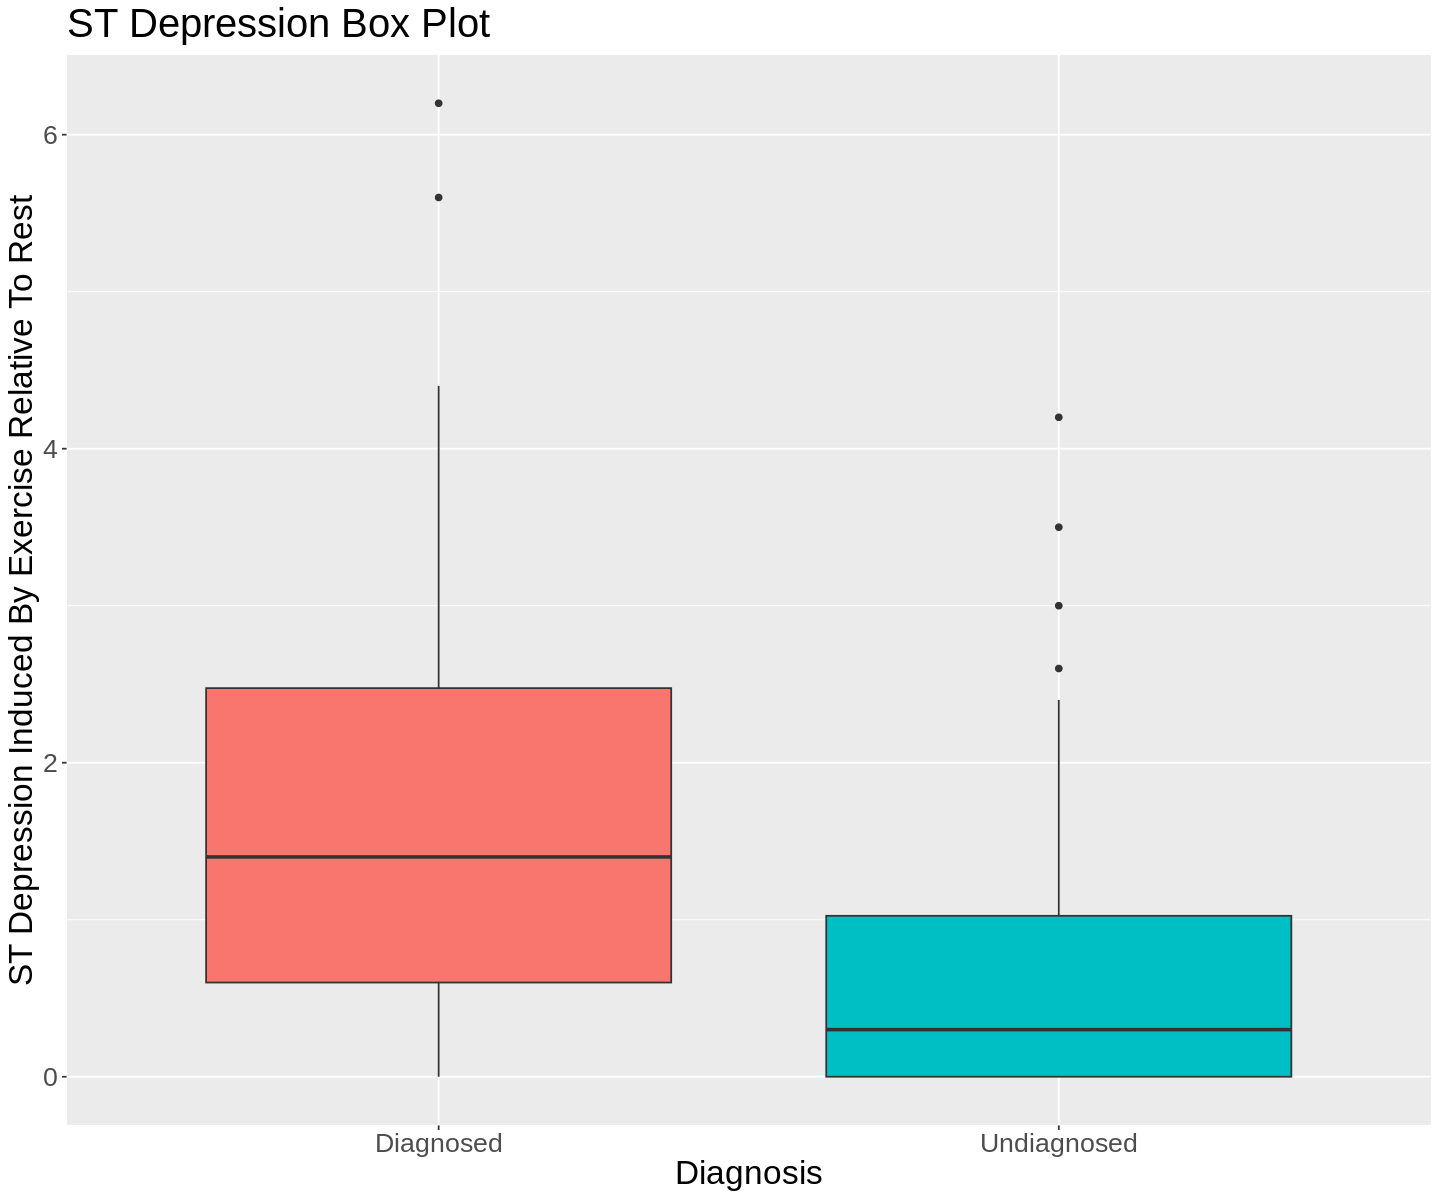

In [9]:
oldpeak_box <- cleveland_train |>
    ggplot(aes(x = diagnosis, y = oldpeak, fill = diagnosis)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "ST Depression Induced By Exercise Relative To Rest",
         color = "Diagnosis") +
    theme(text = element_text(size = 20)) +
    ggtitle("ST Depression Box Plot")

oldpeak_box

Both Undiagnosed and Diagnosed represent a right-skewed distribution according to the median of the data in the box of the ST depression box plot but Diagnosed has a longer whisker on the right, indicating a longer tail towards larger values, which in turn suggests that the data are right-skew. The two datasets exhibit similar distributions, but the positioning of Diagnosed is to the right of the Undiagnosed. Furthermore, the median value of Undiagnosed is lower than the lower quartile of Diagnosed, which suggests a relation between the diagnosis and ST depression.

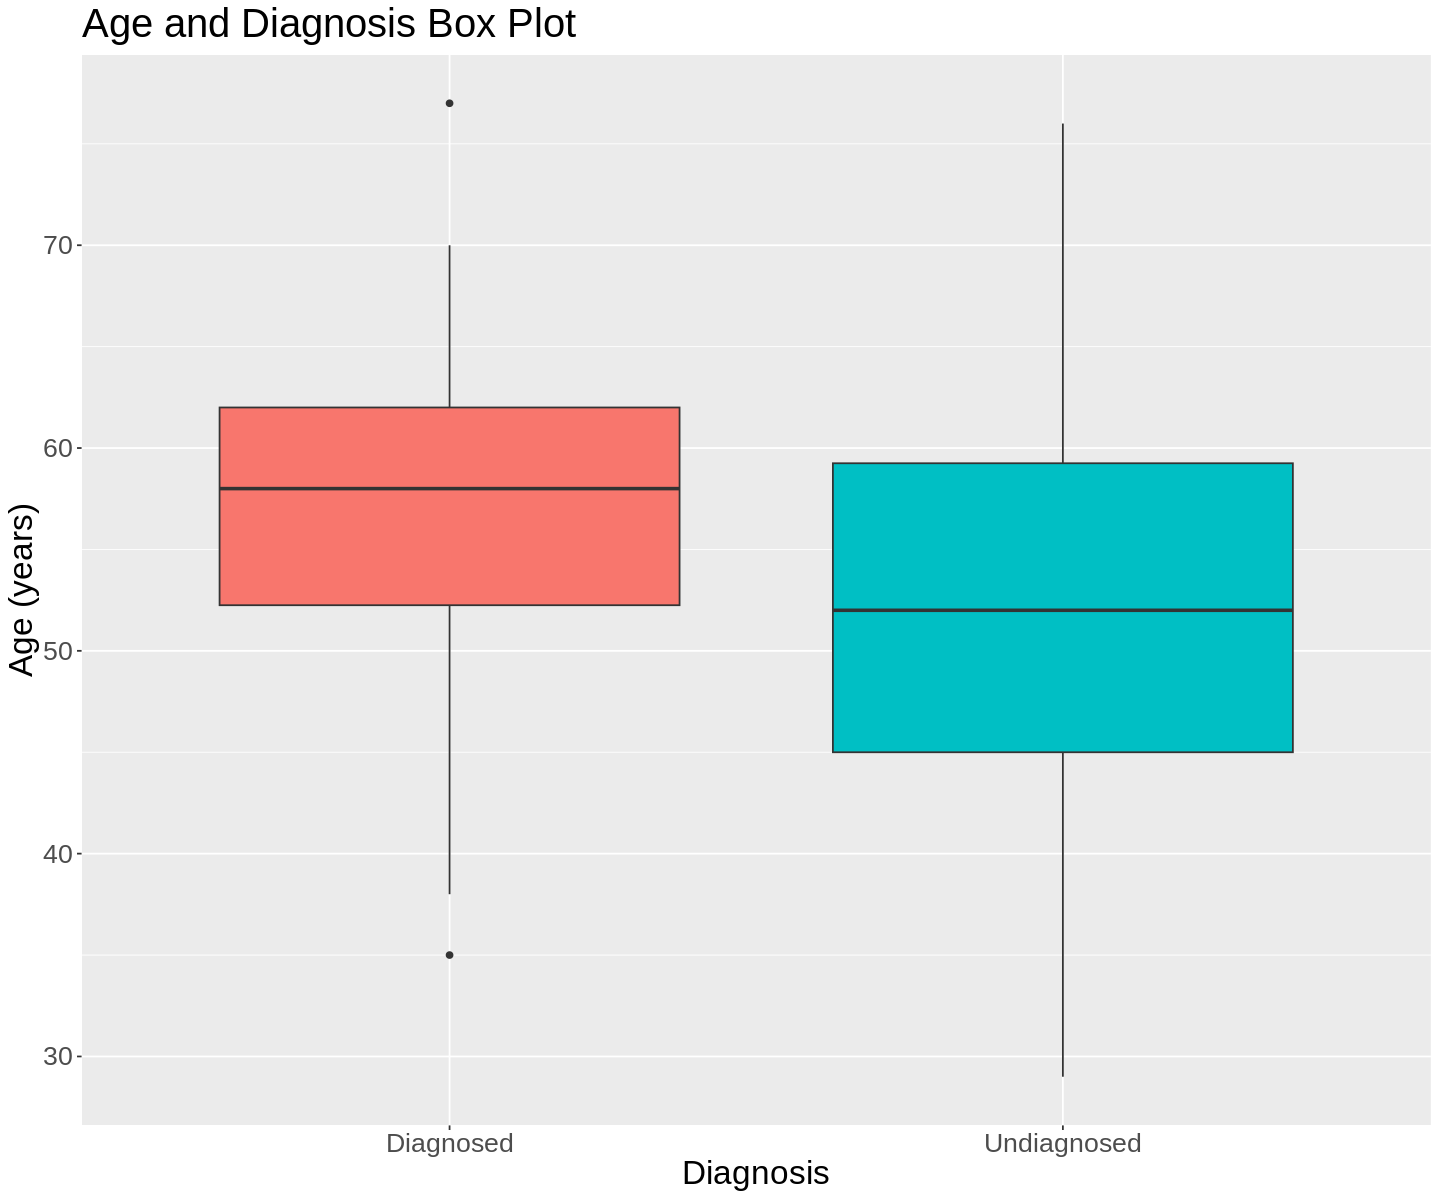

In [10]:
age_box <- cleveland_train |>
    ggplot(aes(x = diagnosis, y = age, fill = diagnosis)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Age (years)",
         color = "Diagnosis") +
    theme(text = element_text(size = 20)) +
    ggtitle("Age and Diagnosis Box Plot")

age_box

In the Age and diagnosis boxplot, both Undiagnosed and Diagnosed exhibit a left-skewed distribution based on the middle 50% of the data in the box, Undiagnosed displays a longer right whisker, indicating a tail towards larger values and implies a right-skewed distribution. From these distributions, we can see that most people who are under about 52 are Undiagnosed and most Diagnosed people are over 58 years old. Therefore, it shows that age has an impact on the diagnosis.

We can create a dataframe to see how much of each class (diagnosed and undiagnosed) makes up the training set.  

In [11]:
diagnosis_distribution <- cleveland_train |>
    group_by(diagnosis) |>
    summarize(count = n(), percentage = paste(round((100*(n()/222)), 2),
                                             "%", sep = ""))

diagnosis_distribution

diagnosis,count,percentage
<chr>,<int>,<chr>
Diagnosed,102,45.95%
Undiagnosed,120,54.05%


We will create a recipe, and we will be using age, serum cholesterol concentration, and maximum heart rate achieved as our predictors for classifying whether or not an individual is diagnosed with heart disease. Since our algorithm depends on distances between observations, we should scale our data to avoid one variable overpowering the other in distance calculations. 

In [12]:
heart_recipe <- recipe(diagnosis ~ age + oldpeak + chol + thalach + trestbps, data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

We will be using the k-nearest neighbours algorithm for classification. We will tune our model and perform cross-validation to see how many models we should use to yield results with highest accuracy. 

In [13]:
set.seed(1000)
heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(cleveland_train, v = 5, strata = diagnosis) 

k = tibble(neighbors = seq(from = 1, to = 50, by = 1)) 

heart_test_k <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = k) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(heart_test_k)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5851515,5,0.02163633,Preprocessor1_Model01
2,accuracy,binary,0.5851515,5,0.02163633,Preprocessor1_Model02
3,accuracy,binary,0.5717172,5,0.02704308,Preprocessor1_Model03
4,accuracy,binary,0.5717172,5,0.02704308,Preprocessor1_Model04
5,accuracy,binary,0.5986869,5,0.02756651,Preprocessor1_Model05
6,accuracy,binary,0.5986869,5,0.02756651,Preprocessor1_Model06


Create a plot to visualize how many neighbours resulted in the highest average accuracy.

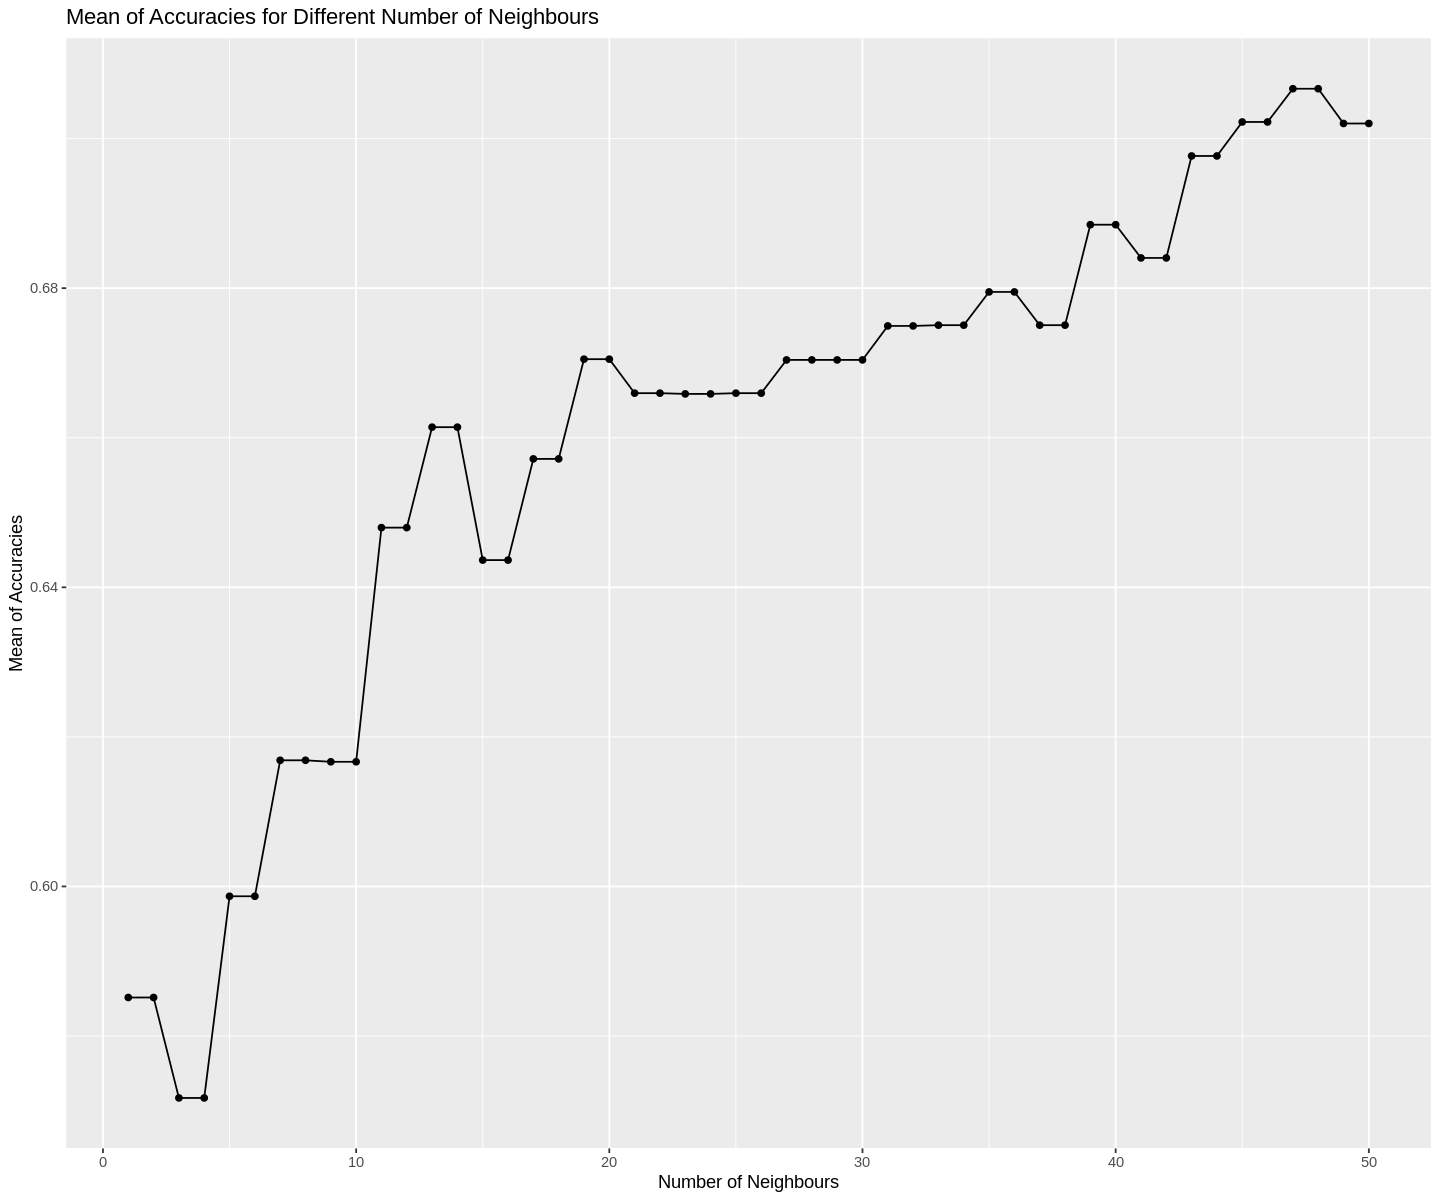

In [14]:
heart_test_k_plot <- heart_test_k|>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbours", y = "Mean of Accuracies") +
    ggtitle("Mean of Accuracies for Different Number of Neighbours")

heart_test_k_plot

To choose the best k, not only do we have to pick one with high average accuracy, but we also have to consider whether it plateaus or not. The averages to the right and left of the value we choose should also yield similar averages. Therefore, a k value that satisfies both criteria would be 32. 

Create a model with the number of neighbours that is expected to give the most accurate results. Combine into a workflow and fit the training set. Make predictions on the testing set based on our model.

In [15]:
heart_best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 32) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_best_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_best_model) |>
    fit(cleveland_train)

heart_predictions <- heart_best_fit |>
    predict(cleveland_test) |>
    bind_cols(cleveland_test) |>
    mutate(diagnosis = as.factor(diagnosis))

head(heart_predictions)

.pred_class,diagnosis,age,chol,thalach,trestbps,oldpeak
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Undiagnosed,Undiagnosed,41,204,172,130,1.4
Diagnosed,Diagnosed,63,254,147,130,1.4
Undiagnosed,Diagnosed,56,256,142,130,0.6
Undiagnosed,Undiagnosed,57,168,174,150,1.6
Undiagnosed,Undiagnosed,54,239,160,140,1.2
Undiagnosed,Undiagnosed,48,275,139,130,0.2


Compare our predicted diagnosis to the true diagnosis of the testing set. Obtain the accuracy of our model.

In [16]:
heart_metrics <- heart_predictions |>
    metrics(truth = diagnosis, estimate = .pred_class)

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7866667
kap,binary,0.5652174


Visualize the confusion matrix to see how many classes of the observations have been correctly predicted.

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


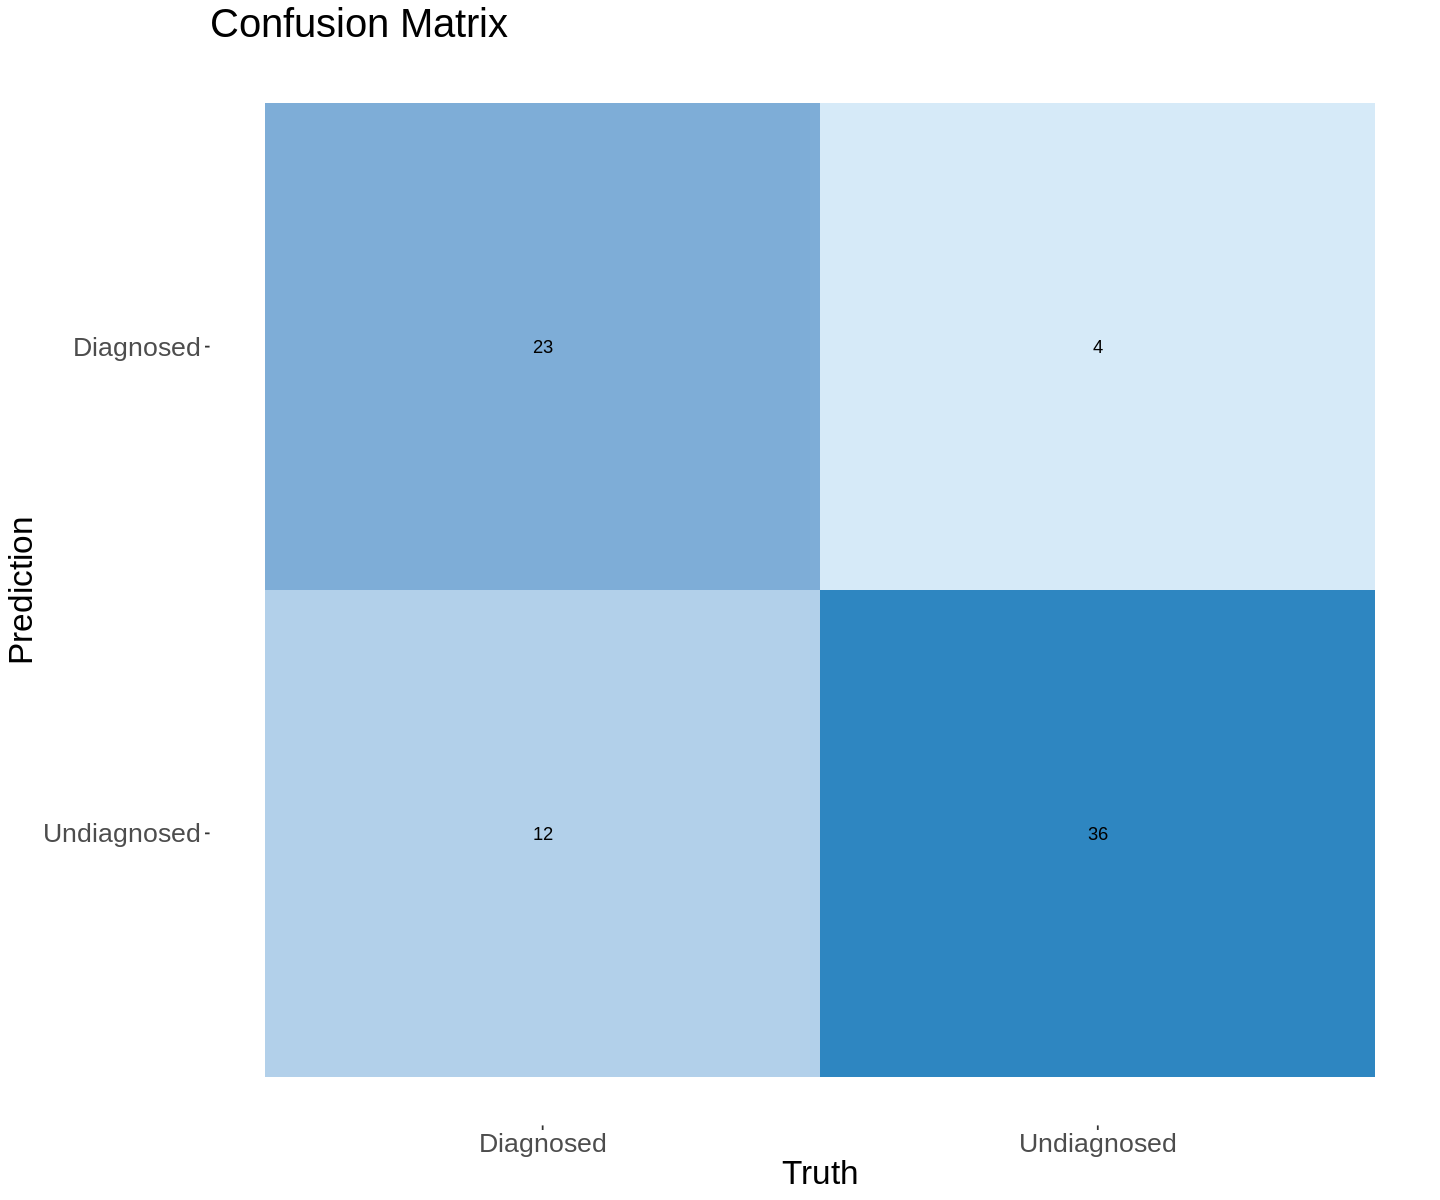

In [17]:
heart_conf_mat <- heart_predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

autoplot(heart_conf_mat, type = "heatmap") +
  scale_fill_gradient(low="#D6EAF8",high = "#2E86C1")+
    ggtitle("Confusion Matrix") +
    theme(text = element_text(size = 20))

**Discussion:**

Based on the Cleveland heart data, we created a model that could predict whether or not an individual has heart disease based on their serum cholesterol concentration, age, maximum heart rate achieved, resting blood pressure, and ST depression induced by exercise relative to rest. These predictors were chosen based on our research on the possible factors that are related to heart diseases. We first tidied the dataset by removing the rows with “?” values and selected the columns which we are concerned in, and then we split it into a training set and a testing set. While we were training the model, we chose to use k = 32 after cross-validation. We then created the workflow for the testing set and used it to predict the diagnosis of the observations in the testing set. Our model achieved an accuracy of 0.7867, or 78.67%. To be more exact, the confusion matrix shows that it has made 23 true positive and 36 true negative predictions and 12 false negative and 4 false positive predictions.

Although this may even seem somewhat low, this was an expected outcome with reference to the box plots produced while exploring our dataset. A possible explanation for the accuracy could arise due to the ambiguity of how our predictors are actually related to the diagnosis of heart diseases. According to our research, the serum cholesterol level of an individual is actually a crucial factor that affects the likelihood of being diagnosed with heart diseases. However, while we were exploring the data, we found that the connection between them is not very clear; this might play a role in disturbing the classifier. Further, this is a similar case with resting blood pressure as we were able to find many research articles to support the connection between resting blood pressure of an individual being related to their diagnosis of heart disease. However, the box plot that was produced suggests that it is not the most significant factor when it comes to diagnosing heart disease. 
    
The implications of this model, first, are very direct– they can help with the diagnosis of heart disease by taking multiple predictors into account in a clinical setting. After clinical tests are performed in a patient to test levels of serum cholesterol concentration, age, maximum heart rate achieved, resting blood pressure, and ST depression induced by exercise, the model can be used to input the data from various tests and observe if heart disease is a potential concern that can be diagnosable for the patient. However, we can’t use this model as a definite predictor for diagnosis just yet, since it is still producing some false negatives and false positives; this may lead to people with heart diseases not receiving medical treatment in time, or people without heart diseases trying to receive medical treatment when it’s not needed, this is why this model should only be used as a suggestion for concern. 

Further, this model can also be used out of clinical settings in order to track data of potential diagnoses of heart diseases. The data then collected can be used for various applications, including keeping track of the overall heart health of citizens and also further in making potential amendments to the healthcare system. 

In the future, this model can be improved on by making it more flexible to indicate the extent to which certain predictors are influencing the classification (whether it is “Diagnosed” or “Undiagnosed”). Implementing this in the models can help indicate to doctors/health professionals what specific predictors of heart disease are at play. This specificity will reduce ambiguity in the diagnosis and provide a clear cut direction as to the predictors that need to be treated in patients. 

Additionally, the model can be improved in the future to include another classifier for patients at the borderline of heart disease– the patients who have not been diagnosed with heart disease but are showing signs of developing it in the future. 


Finally, the accuracy of the classifier can also be improved through implementing a statistical diagnosis on likelihood ratios (LR’s). According to a report by The National Library of Medicine, likelihood ratios determine the probability of the classification (Shreffler & Huecker, 2023). In the case of our model, positive likelihood ratios can be used to numerically explain the event of a “Diagnosed” classification by dividing the probability of a patient being diagnosed with the probability of false positives. Negative likelihood ratios can be used to numerically explain the opposite- with the “Undiagnosed” classification. 



**References:**

Shreffler, J., & Huecker, M. R. (2023, March 6). Diagnostic Testing Accuracy: Sensitivity, Specificity, Predictive Values and Likelihood Ratios - StatPearls - NCBI Bookshelf. https://www.ncbi.nlm.nih.gov/books/NBK557491/

Lanza, G. A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G. A., & Crea, F. (2004, March 10). Diagnostic and prognostic value of ST segment depression limited to the recovery phase of exercise stress test. PubMed Central (PMC). https://doi.org/10.1136/hrt.2003.031260

Solan, M. (2021, November 16). Your resting heart rate can reflect your current and future health. Harvard Health. https://www.health.harvard.edu/blog/your-resting-heart-rate-can-reflect-your-current-and-future-health-201606172482

Law, M., Wald, N. J., & Thompson, S. E. (1994). By how much and how quickly does reduction in serum cholesterol concentration lower risk of ischaemic heart disease? BMJ, 308(6925), 367–372. https://doi.org/10.1136/bmj.308.6925.367

Pepine, C. J.; Abrams, J.; Marks, R. G.; Morris, J. J.; Scheidt, S. S.; Handberg, E.; The TIDES Investigators. Characteristics of a Contemporary Population with Angina Pectoris. The American Journal of Cardiology 1994, 74 (3), 226–231. https://doi.org/10.1016/0002-9149(94)90361-1

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in Cardiovascular Diseases, 52(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003

Sandvik, L., Erikssen, J., Ellestad, M. H., Erikssen, G., Thaulow, E., Mundal, R., & Rodahl, K. (1995). Heart rate increase and maximal heart rate during exercise as predictors of cardiovascular mortality. Coronary Artery Disease, 6(8), 667–680. https://doi.org/10.1097/00019501-199508000-00012

**Members:**

Jasleen Saini

Lily Liu

Allan Wang

Deeksha Yelamanchi